# Experiment on passing i.i.d. data to pyro.condition


(Building the same model as pyro documentation: http://pyro.ai/examples/intro_part_ii.html#Conditioning-Models-on-Data)

In [194]:
# import some dependencies
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns
sns.set(style="ticks")

import torch

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

torch.manual_seed(101);

## Model

In [195]:
def scale(guess):
    # The prior over weight encodes our uncertainty about our guess
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    # This encodes our belief about the noisiness of the scale:
    # the measurement fluctuates around the true weight
    return pyro.sample("measurement", dist.Normal(weight, 0.75))

## Conditioning Models on Data

tensor(9.3207)


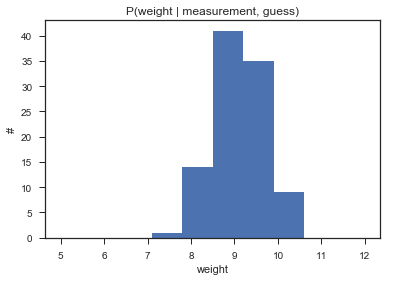

In [196]:
guess = 8.5
measurement = 9.5

conditioned_scale = pyro.condition(scale, data={"measurement": measurement})

marginal = pyro.infer.EmpiricalMarginal(
    pyro.infer.Importance(conditioned_scale, num_samples=100).run(guess), sites="weight")

# The marginal distribution concentrates around the data
print(marginal())
plt.hist([marginal().item() for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#");

## Conditioning Model with i.i.d. Data

In [197]:
# Number of i.i.d. samples
N = 100
subsample_size = 10

# sample i.i.d points
measurement = dist.Normal(16,2).independent().sample(sample_shape = torch.Size([N]))

# condition
with pyro.iarange("data", len(measurement), subsample_size=subsample_size) as ind:
    measurement_batch = measurement[[ind]]
    conditioned_scale = pyro.condition(scale, data={"measurement": measurement_batch})

num_samples = 1000
marginal = pyro.infer.EmpiricalMarginal(
    pyro.infer.Importance(conditioned_scale, num_samples=1000).run(measurement_batch), sites="weight")

## Plot Marginals

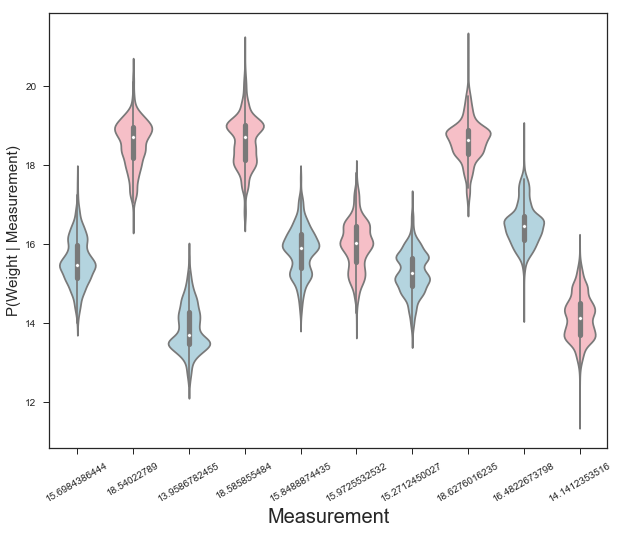

In [198]:
df = pd.DataFrame(0, index=np.arange(num_samples), columns=measurement_batch)

for i in range(0,subsample_size):
    df[measurement_batch[i]] = [marginal()[i].item() for _ in range(num_samples)]

fig, ax = plt.subplots()
ax.set_xlabel('Measurement',fontsize=20)
ax.set_ylabel('P(Weight | Measurement)',fontsize=15)
fig.set_size_inches(10, 8)
a = sns.violinplot(data=df,
               palette=["lightblue", "lightpink"]);

plt.xticks(rotation=30);